In [1]:
%matplotlib inline
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', None)


## Carga de Datos

In [2]:
main_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
main_dir

'/home/diego/got-rag-chatbot'

In [3]:
def load_and_process_results(path):
    if not os.path.exists(path):
        print(f"❌ No se encontró el archivo: {path}")
        return pd.DataFrame()

    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
                
    df = pd.DataFrame(data)
    
    if df.empty:
        return df


    if 'source' in df.columns and 'evidence_source' not in df.columns:
        df = df.rename(columns={'source': 'evidence_source'})
        print("🔧 Columna 'source' renombrada a 'evidence_source'.")

    if 'metrics' in df.columns:
        metrics_data = df['metrics'].tolist()
        metrics_df = pd.json_normalize(metrics_data)
        
        df = pd.concat([df.drop(columns=['metrics']), metrics_df], axis=1)
        print("✅ Métricas extraídas: context_recall, faithfulness, correctness, reason.")
    
    # Llenar nulos por seguridad
    fill_defaults = {
        'context_recall': 0, 'faithfulness': 0, 'correctness': 0, 
        'evidence_source': 'Unknown', 'reason': 'N/A'
    }
    for col, val in fill_defaults.items():
        if col in df.columns:
            df[col] = df[col].fillna(val)

    return df

In [4]:
RESULTS_PATH = os.path.join(main_dir, 'data', 'eval', 'evaluation_results_neo4j_v1.jsonl')

# Cargar y verificar
df = load_and_process_results(RESULTS_PATH)

print(f"✅ Registros cargados: {len(df)}")
print(f"📋 Columnas finales: {df.columns.tolist()}")

# Verificar que 'evidence_source' existe ahora
if 'evidence_source' not in df.columns:
    print("⚠️ ALERTA: La columna 'evidence_source' sigue faltando. Verifica el archivo jsonl.")
else:
    display(df.head(2))

🔧 Columna 'source' renombrada a 'evidence_source'.
✅ Métricas extraídas: context_recall, faithfulness, correctness, reason.
✅ Registros cargados: 170
📋 Columnas finales: ['id', 'question', 'type', 'evidence_source', 'prediction', 'ground_truth', 'context_recall', 'faithfulness', 'correctness', 'reason']


,id,question,type,evidence_source,prediction,ground_truth,context_recall,faithfulness,correctness,reason
0,neo4j_0,What is the seat of House Redwyne?,Relationship,Graph,The seat of House Redwyne is Arbor.,Arbor,1,1,1,"The retrieved context explicitly states 'The seat of House Redwyne is Arbor', which matches the ground truth. The prediction accurately reflects this information from the context."
1,neo4j_1,Who is the head of House Redwyne?,Relationship,Graph,"Lord Paxter Redwyne is the head of House Redwyne. He is the first cousin and oldest friend of his liege lord, Mace Tyrell, and serves as high admiral and commander of the Reach's fleet.",Lord Paxter Redwyne,1,1,1,"The retrieved context explicitly states that 'Lord Paxter Redwyne is the head of House Redwyne', which directly answers the question and matches the ground truth. The prediction is derived entirely from the provided context, and it correctly identifies Lord Paxter Redwyne as the head of House Redwyne, satisfying the inclusive match for correctness."


## Métricas Globales (KPIs)

In [5]:
if not df.empty:
    # 1. Cálculos de promedios (multiplicamos por 100 para porcentaje)
    recall_global = df['context_recall'].mean() * 100
    faith_global = df['faithfulness'].mean() * 100
    acc_global = df['correctness'].mean() * 100
    
    total = len(df)
    
    # 2. Conteo de tipos de fallos
    # Fallo de Recuperación: El retriever trajo basura (context_recall = 0)
    retrieval_fails = len(df[df['context_recall'] == 0])
    
    # Fallo de Razonamiento: El retriever trajo el dato bien, pero el LLM falló al responder
    # (context_recall = 1 AND correctness = 0)
    reasoning_fails = len(df[(df['context_recall'] == 1) & (df['correctness'] == 0)])
    
    # Alucinaciones: El LLM inventó datos (faithfulness = 0)
    hallucinations = len(df[df['faithfulness'] == 0])

    # 3. Impresión del Reporte
    print("="*60)
    print(f"📊 REPORTE DE EVALUACIÓN MULTI-MÉTRICA (GraphRAG)")
    print("="*60)
    print(f"Evaluando {total} preguntas generadas desde Neo4j.")
    print("-" * 60)
    print(f"🔍 Context Recall (Calidad del Retriever):  {recall_global:.2f}%")
    print(f"   -> ¿El sistema encontró la información necesaria?")
    print("-" * 60)
    print(f"🤖 Faithfulness (Control de Alucinaciones): {faith_global:.2f}%")
    print(f"   -> ¿La respuesta se basó SOLO en el contexto?")
    print("-" * 60)
    print(f"🎯 Correctness (Precisión Final):           {acc_global:.2f}%")
    print(f"   -> ¿La respuesta final es correcta?")
    print("="*60)
    
    print(f"\n🩺 DIAGNÓSTICO DE FALLOS:")
    print(f"❌ Fallos de Recuperación (Dato no encontrado):   {retrieval_fails} ({retrieval_fails/total:.1%})")
    print(f"🧠 Fallos de Razonamiento (Dato mal interpretado): {reasoning_fails} ({reasoning_fails/total:.1%})")
    print(f"👻 Alucinaciones Detectadas:                      {hallucinations} ({hallucinations/total:.1%})")

else:
    print("⚠️ El dataframe está vacío. Ejecuta primero 'judge.py'.")

📊 REPORTE DE EVALUACIÓN MULTI-MÉTRICA (GraphRAG)
Evaluando 170 preguntas generadas desde Neo4j.
------------------------------------------------------------
🔍 Context Recall (Calidad del Retriever):  92.94%
   -> ¿El sistema encontró la información necesaria?
------------------------------------------------------------
🤖 Faithfulness (Control de Alucinaciones): 98.82%
   -> ¿La respuesta se basó SOLO en el contexto?
------------------------------------------------------------
🎯 Correctness (Precisión Final):           89.41%
   -> ¿La respuesta final es correcta?

🩺 DIAGNÓSTICO DE FALLOS:
❌ Fallos de Recuperación (Dato no encontrado):   12 (7.1%)
🧠 Fallos de Razonamiento (Dato mal interpretado): 6 (3.5%)
👻 Alucinaciones Detectadas:                      2 (1.2%)


## Análisis por Fuente de Evidencia (Grafo vs Texto)

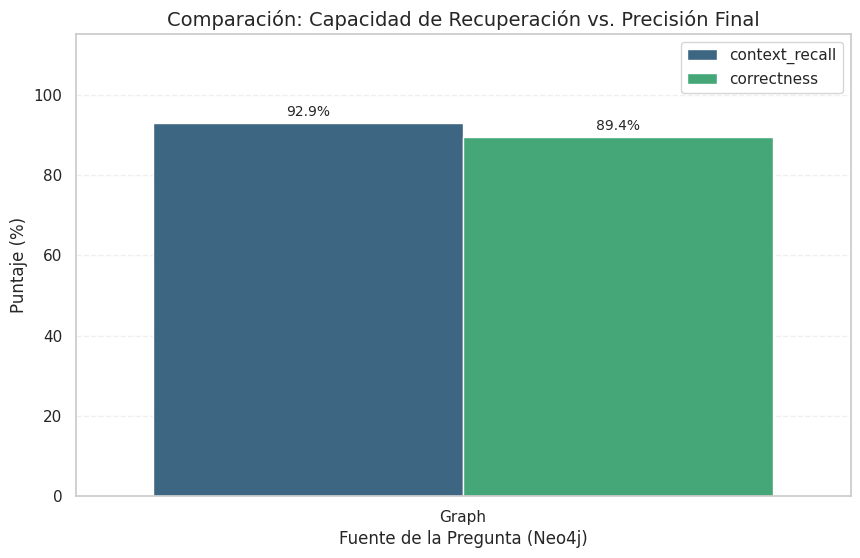

In [6]:
if not df.empty and 'evidence_source' in df.columns:
    # Transformamos los datos a formato "largo" para Seaborn
    # Queremos comparar Recall y Correctness lado a lado
    melted_df = df.melt(
        id_vars=['evidence_source'], 
        value_vars=['context_recall', 'correctness'], 
        var_name='Métrica', 
        value_name='Puntaje'
    )
    melted_df['Puntaje'] *= 100  # A escala 0-100

    plt.figure(figsize=(10, 6))
    
    # Crear gráfico de barras agrupado
    ax = sns.barplot(
        data=melted_df,
        x='evidence_source',
        y='Puntaje',
        hue='Métrica',
        palette="viridis",
        errorbar=None  # Quitamos las barras de error para limpieza visual
    )
    
    plt.title('Comparación: Capacidad de Recuperación vs. Precisión Final', fontsize=14)
    plt.ylabel('Puntaje (%)', fontsize=12)
    plt.xlabel('Fuente de la Pregunta (Neo4j)', fontsize=12)
    plt.ylim(0, 115)  # Un poco más de 100 para que quepan las etiquetas
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Añadir etiquetas de valor encima de las barras
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3, fontsize=10)

    plt.show()
else:
    print("⚠️ Faltan datos para generar la gráfica.")

## Auditoría de Fallos

In [7]:
if not df.empty and 'evidence_source' in df.columns:
    # 1. Categorizar errores
    def categorize_error(row):
        # Usamos .get() para evitar errores si la columna no existe por alguna razón
        if row.get('context_recall', 0) == 0:
            return "❌ Retrieval Fail (No Info)"
        elif row.get('correctness', 0) == 0:
            return "🧠 Reasoning Fail (Bad Answer)"
        elif row.get('faithfulness', 0) == 0:
            return "👻 Hallucination"
        return "✅ Correct"

    df['Diagnóstico'] = df.apply(categorize_error, axis=1)

    # 2. Filtrar fallos
    df_failures = df[df['Diagnóstico'] != "✅ Correct"].copy()
    
    print(f"🔍 Analizando {len(df_failures)} errores encontrados:")

    # 3. Seleccionar columnas que SÍ existen
    potential_cols = ['question', 'prediction', 'ground_truth', 'evidence_source', 'Diagnóstico', 'reason']
    cols_to_show = [c for c in potential_cols if c in df_failures.columns]

    if not df_failures.empty:
        # 4. Mostrar tabla
        display(df_failures[cols_to_show]
         .sample(min(10, len(df_failures)))
         .style
         .set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})
         .set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
         .map(lambda v: 'color: red; font-weight: bold;' if 'Fail' in str(v) else '', subset=['Diagnóstico']) # <--- CAMBIO AQUÍ
        )
    else:
        print("🎉 ¡No hay errores! Todo perfecto (o no hay datos de fallos).")
else:
    print("⚠️ No se puede generar la tabla: Faltan datos o la columna 'evidence_source'.")

🔍 Analizando 18 errores encontrados:


,question,prediction,ground_truth,evidence_source,Diagnóstico,reason
62,What is the Fandom URL for Black Ears?,The archives are silent on this.,https://gameofthrones.fandom.com/wiki/?curid=4185,Graph,❌ Retrieval Fail (No Info),"The retrieved context does not contain the Fandom URL for 'Black Ears' (context recall = 0). The prediction accurately states that the information is not found, which is faithful to the provided context (faithfulness = 1). However, since the ground truth provides the URL, and the prediction states it's unknown, correctness is 0."
77,What is the culture of Timett (father of Timett)?,The archives are silent on this.,Hill tribes,Graph,🧠 Reasoning Fail (Bad Answer),"The retrieved context states that 'Timett, son of Timett, is the leader of the Burned Men, one of the hill tribes'. This implies the culture of the family/lineage, including the father, is 'Hill tribes'. Therefore, the information required for the Ground Truth is present. However, the Prediction states 'The archives are silent on this', which is a hallucination as the context contains relevant information. Consequently, the Prediction is not faithful and is incorrect as it contradicts the Ground Truth by claiming lack of information."
100,Which house is Dark Sister owned by?,The archives are silent on this.,House Targaryen/House of the Dragon,Graph,❌ Retrieval Fail (No Info),"The retrieved context does not contain any information about 'Dark Sister' or its ownership by House Targaryen, so Context Recall is 0. The prediction correctly states that the information is not available in the provided context, making it faithful. However, since the Ground Truth provides the correct answer, and the prediction states it's unknown, Correctness is 0."
141,Name another house that is located in Dorne.,House Blackmont is located in Dorne.,House Dayne,Graph,🧠 Reasoning Fail (Bad Answer),"The retrieved context contains the ground truth 'House Dayne' and other houses in Dorne, including 'House Blackmont'. The prediction 'House Blackmont is located in Dorne.' is entirely derived from the retrieved context. However, for correctness, the 'Inclusive Match' rule states that the prediction must CONTAIN the ground truth. Since 'House Blackmont' does not contain 'House Dayne', and the ground truth is provided as the verified correct answer, the correctness score is 0, even though 'House Blackmont' is also a factually correct answer to the question based on the context."
19,Which house is Sarra affiliated with?,"Sarra Frey is affiliated with House Frey, being one of the many granddaughters of Walder Frey. The archives are silent on the house affiliation of the Sarra present at Winterfell during the celebration of the victory in the Battle of Winterfell.",House Stark,Graph,❌ Retrieval Fail (No Info),"Context Recall: The Ground Truth states 'House Stark'. The retrieved context does not contain this information for any relevant Sarra. It explicitly states 'The provided data does not contain information about Sarra's house affiliation' for the subject of inquiry, and for Sarra at Winterfell, it says she shares no similarities with 'Sarra Stark' from the books. Faithfulness: The prediction correctly identifies Sarra Frey's affiliation from the context and also correctly states that the archives are silent on the Sarra at Winterfell, which is also supported by the context. Correctness: The Ground Truth is 'House Stark', but the prediction does not provide 'House Stark' for Sarra. Instead, it provides 'House Frey' for a different Sarra and 'Unknown' for the relevant Sarra, thus contradicting or missing the Ground Truth."
73,What weapon is owned by House Baratheon of Kings Landing?,The archives are silent on this.,Widows Wail,Graph,❌ Retrieval Fail (No Info),"Context Recall is 0 because 'Widows Wail' or any weapon owned by House Baratheon of Kings Landing is not mentioned in the retrieved context. Faithfulness is 1 because the prediction correctly states that the information is n